# D2M1_2_supervisado_ejercicio

## Cargue librerias

In [1]:
%%capture
pip install rasterio

In [11]:
import re
import os
import zipfile
import geopandas as gpd
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.features import rasterize
from pathlib import Path

In [3]:
os.chdir("/content")

## Lectura y exploración de datos

Se crea una carpeta llamada `1_insumos`, descarga dos archivos ZIP desde GitHub (uno vectorial y otro ráster), los descomprime dentro de esa carpeta y luego elimina los ZIP para ahorrar espacio.

In [4]:
%%capture
#Crear carpeta para almacenar insumos
os.makedirs("/content/1_insumos", exist_ok=True)

#Descargar el ZIP desde GitHub
!wget https://github.com/Luisafrodriguezo1/Diplomado_PDI/raw/main/D2M1_2_supervisado/1_Insumo_D2M1_2_supervisado/1_Vectorial.zip -O /content/1_insumos/1_Vectorial.zip

#Descomprimir
!unzip /content/1_insumos/1_Vectorial.zip -d /content/1_insumos


In [5]:
%%capture
!wget https://github.com/Luisafrodriguezo1/Diplomado_PDI/raw/main/D2M1_2_supervisado/1_Insumo_D2M1_2_supervisado/2_Raster.zip -O /content/1_insumos/2_Raster.zip

!unzip /content/1_insumos/2_Raster.zip -d /content/1_insumos


In [6]:
# remover zip
!rm /content/1_insumos/*.zip

**Imagenes**

Lee los archivos `.tif`, obtiene información básica de cada raster (CRS, número de bandas, dimensiones, mínimo y máximo real de píxeles) y organiza todo en una tabla para revisión.

In [8]:
path_insumos = "1_insumos"
data = []

for root, _, files in os.walk(path_insumos):# Recorre todas las carpetas y subcarpetas
    for f in files:
        if f.lower().endswith(".tif"):
            path = os.path.join(root, f)
            try:
                with rasterio.open(path) as src:

                    arr = src.read(1)
                    min_val= float(np.nanmin(arr))
                    max_val = float(np.nanmax(arr))

                    data.append({
                        "archivo": f,
                        "crs": src.crs.to_string() if src.crs is not None else None,
                        "bandas": src.count,
                        "dtype": src.dtypes[0],
                        "dimensiones": f"{src.width} x {src.height}",
                        "min_val": round(min_val, 4),
                        "max_val": round(max_val, 4)
                    })
            except Exception as e:
                print(f"Error al leer {path}: {e}")

df = pd.DataFrame(data)
df


,archivo,crs,bandas,dtype,dimensiones,min_val,max_val
0,LC08_L2SP_008056_20200322_20200822_02_T1_SR_B5...,EPSG:32618,1,float32,1679 x 1548,-1.0,52560.0
1,LC08_L2SP_008056_20200322_20200822_02_T1_SR_B2...,EPSG:32618,1,float32,1679 x 1548,-1.0,40822.0
2,LC08_L2SP_008056_20200322_20200822_02_T1_SR_B4...,EPSG:32618,1,float32,1679 x 1548,-1.0,44700.0
3,LC08_L2SP_008056_20200322_20200822_02_T1_SR_B7...,EPSG:32618,1,float32,1679 x 1548,-1.0,63360.0
4,LC08_L2SP_008056_20200322_20200822_02_T1_SR_B6...,EPSG:32618,1,float32,1679 x 1548,-1.0,60532.0
5,LC08_L2SP_008056_20200322_20200822_02_T1_SR_B3...,EPSG:32618,1,float32,1679 x 1548,-1.0,41795.0


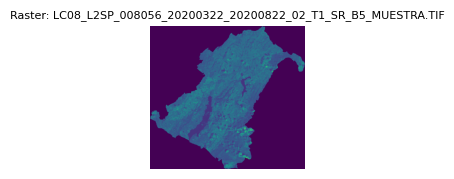

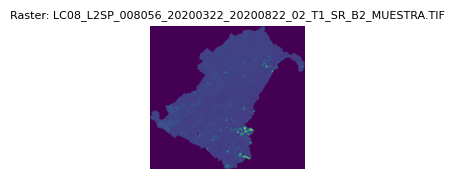

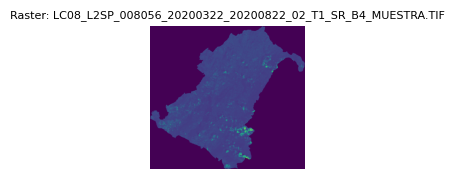

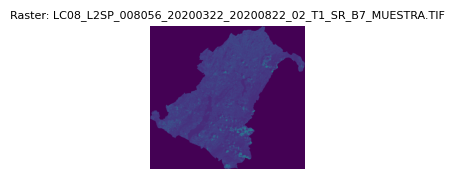

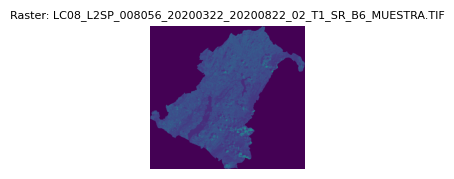

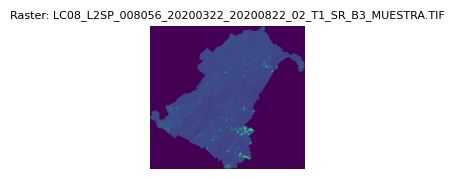

In [9]:
for root, _, files in os.walk(path_insumos):
    for f in files:
        if f.lower().endswith(".tif"):
            path = os.path.join(root, f)

            with rasterio.open(path) as src:
                img = src.read(1)
                plt.figure(figsize=(2,2))
                plt.imshow(img, cmap="viridis")
                plt.title(f"Raster: {f}", fontsize=8)
                plt.axis("off")
                plt.show()

Se observa que todas las capas ráster comparten las mismas características espaciales y de datos: sistema de referencia CRS **EPSG:32618**, una única banda, tipo de dato **float32** y dimensiones iguales (**1679 x 1548 píxeles**)

**Capa Vectorial**

Se lee el shapefile y se confirma que tiene el CRS EPSG:32618, el mismo sistema de coordenadas de los ráster

In [9]:
shp = "1_insumos/1_Vectorial/e_cobertura_tierra_2020_muestra.shp"
gdf = gpd.read_file(shp)

print("CRS del shapefile:", gdf.crs)
gdf.head()

CRS del shapefile: EPSG:32618


,OBJECTID,codigo,leyenda,insumo,apoyo,confiabili,cambio,nivel_1,nivel_2,nivel_3,...,nom_dpto,nom_mpio,Cod_dane_m,Categoria,Cod_dane_d,cod_aa,nom_aa,SHAPE_Leng,SHAPE_Area,geometry
0,95161.0,321113,3.2.1.1.1.3. Herbazal denso de tierra firme c...,Landsat_2020_Mediana_07042021,Sentinel2_NXL_20200205,SI,1,3,32,321,...,Cundinamarca,Chocontá,25183,1,25,CAR,CORPORACION AUTONOMA REGIONAL DE CUNDINAMARCA,0.033434,0.000022,"MULTIPOLYGON (((660730.197 568211.466, 660658...."
1,95170.0,244,2.4.4. Mosaico de pastos con espacios naturales,Landsat_2020_Mediana_07042021,Sentinel2_NYJ_20200210,SI,1,2,24,244,...,Cundinamarca,Chocontá,25183,1,25,CAR,CORPORACION AUTONOMA REGIONAL DE CUNDINAMARCA,0.022559,0.000005,"MULTIPOLYGON (((661757.207 566159.392, 661757...."
2,95172.0,3222,3.2.2.2. Arbustal abierto,Landsat_2020_mediana_07042021,None,SI,1,3,32,322,...,Cundinamarca,Suesca,25772,1,25,CAR,CORPORACION AUTONOMA REGIONAL DE CUNDINAMARCA,0.051244,0.000026,"POLYGON ((629350.994 567284.446, 629335.032 56..."
3,95173.0,231,2.3.1. Pastos limpios,Landsat_2020_mediana_07042021,None,SI,1,2,23,231,...,Cundinamarca,Suesca,25772,1,25,CAR,CORPORACION AUTONOMA REGIONAL DE CUNDINAMARCA,0.067093,0.000030,"MULTIPOLYGON (((628081.593 560841.725, 628049...."
4,95174.0,225,2.2.5. Cultivos confinados,Landsat_2020_mediana_07042021,None,SI,1,2,22,225,...,Cundinamarca,Suesca,25772,1,25,CAR,CORPORACION AUTONOMA REGIONAL DE CUNDINAMARCA,0.023015,0.000023,"POLYGON ((628874.143 558275.941, 628747.431 55..."


In [10]:
gdf.columns

Index(['OBJECTID', 'codigo', 'leyenda', 'insumo', 'apoyo', 'confiabili',
       'cambio', 'nivel_1', 'nivel_2', 'nivel_3', 'nivel_4', 'nivel_5',
       'nivel_6', 'area_ha', 'nom_dpto', 'nom_mpio', 'Cod_dane_m', 'Categoria',
       'Cod_dane_d', 'cod_aa', 'nom_aa', 'SHAPE_Leng', 'SHAPE_Area',
       'geometry'],
      dtype='object')

Se identifican los municipios presentes en la capa (Chocontá, Suesca, Tocancipá, Guatavita, Gachancipá y Sesquilé) y las categorías del campo nivel_1, que corresponden a las etiquetas utilizadas en este ejercicio.

In [11]:
print("Municipios de la capa", gdf['nom_mpio'].unique())
print("Nivel 1", gdf['nivel_1'].unique())

Municipios de la capa ['Chocontá' 'Suesca' 'Tocancipá' 'Guatavita' 'Gachancipá' 'Sesquilé']
Nivel 1 ['3' '2' '1' '5' '4']


Recuerde
| Nivel 1 | Nombre                          |
|---------|---------------------------------|
| 1       | Territorios Artificializados   |
| 2       | Territorios Agrícolas          |
| 3       | Bosques y Áreas Seminaturales  |
| 4       | Áreas Húmedas                  |
| 5       | Superficies de Agua            |


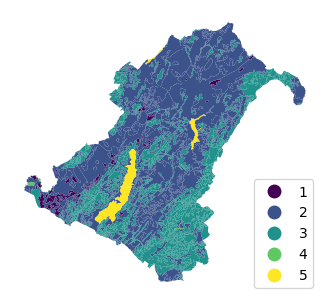

In [12]:
ax = gdf.plot(column="nivel_1",cmap="viridis",legend=True,figsize=(4,4),legend_kwds={"loc": "lower right"})
ax.set_axis_off()


## Construcción conjunto de datos

Se crean tres carpetas para organizar el flujo del proyecto: 2_procesado para los datos procesados, 3_modelo para los modelos entrenados y 4_prediccion para guardar los resultados de predicción.

In [12]:
path_proc = Path("/content/2_procesado")
path_model = Path("/content/3_modelo")
path_pred  = Path("/content/4_prediccion")

for p in [path_proc, path_model, path_pred]:
    p.mkdir(parents=True, exist_ok=True)
    print(p)



/content/2_procesado
/content/3_modelo
/content/4_prediccion


Se configuran las rutas de entrada a los ráster y al shapefile, se define el campo de clase que contiene las etiquetas, el patrón para seleccionar los archivos ráster a utilizar y la opción para trabajar solo con píxeles puros en la clasificación.

In [14]:
dir_rasters = Path("/content/1_insumos/2_Raster")
ruta_shp    = "/content/1_insumos/1_Vectorial/e_cobertura_tierra_2020_muestra.shp"
campo_clase = "nivel_1"
patron      = "*_SR_B*.TIF"
usar_pixel_puro = True

In [23]:
def band_order_key(p: Path):
    """
    Extrae el número de banda del nombre de un archivo ráster para usarlo como
    criterio de ordenamiento.

    Parámetros
    ----------
    p : Path
        Ruta del archivo a evaluar. Se espera que el nombre del archivo contenga
        una banda en el formato "B{número}", por ejemplo: "imagen_B04.tif".

    Retorna
    -------
    int
        Número de la banda encontrado en el nombre del archivo. Si no se identifica
        ninguna banda en el nombre, devuelve 999 para posicionar ese archivo al final.
    """

    m = re.search(r"B(\d+)", p.name.upper())
    print(m)


    return int(m.group(1)) if m else 999


In [24]:
rasters = sorted(dir_rasters.glob(patron), key=band_order_key)
if not rasters:
    raise FileNotFoundError(f"No hay TIF con patrón {patron} en {dir_rasters}")
print("Bandas:")
for r in rasters: print(" -", r.name)

<re.Match object; span=(44, 46), match='B5'>
<re.Match object; span=(44, 46), match='B2'>
<re.Match object; span=(44, 46), match='B4'>
<re.Match object; span=(44, 46), match='B7'>
<re.Match object; span=(44, 46), match='B6'>
<re.Match object; span=(44, 46), match='B3'>
Bandas:
 - LC08_L2SP_008056_20200322_20200822_02_T1_SR_B2_MUESTRA.TIF
 - LC08_L2SP_008056_20200322_20200822_02_T1_SR_B3_MUESTRA.TIF
 - LC08_L2SP_008056_20200322_20200822_02_T1_SR_B4_MUESTRA.TIF
 - LC08_L2SP_008056_20200322_20200822_02_T1_SR_B5_MUESTRA.TIF
 - LC08_L2SP_008056_20200322_20200822_02_T1_SR_B6_MUESTRA.TIF
 - LC08_L2SP_008056_20200322_20200822_02_T1_SR_B7_MUESTRA.TIF


In [26]:
def leer_stack(paths):
    """
    Lee múltiples archivos ráster y los apila en una sola matriz,
    asumiendo que todos tienen el mismo tamaño espacial y el mismo CRS.

    Parámetros
    ----------
    paths : list[Path] o list[str]
        Lista de rutas de archivos TIF que representan diferentes bandas.

    Retorna
    -------
    stack : numpy.ndarray
        Arreglo con forma (B, H, W), donde:
        B = número de bandas
        H = alto del ráster
        W = ancho del ráster

    meta_ref : dict
        Metadatos del primer archivo ráster (CRS, transformada, perfil del dato)
        que se pueden usar para guardar el resultado nuevamente en un archivo TIF.
    """

    bands = []
    meta_ref = None

    for i, tif in enumerate(paths):
        print(f"i={i}", f"tif={tif}")

        with rasterio.open(tif) as src:
            arr = src.read(1)

            if i == 0:
                meta_ref = src.meta.copy()

            bands.append(arr)


    stack = np.stack(bands, axis=0)  # (B, H, W)

    print(meta_ref)

    return stack, meta_ref


Se crea un stack con todas las bandas ráster apiladas en una matriz 3D (bandas, alto y ancho)

In [27]:
stack, meta = leer_stack(rasters)      # (B, H, W)
B, H, W = stack.shape
print(f"Stack listo: {stack.shape} (B,H,W)")

i=0 tif=/content/1_insumos/2_Raster/LC08_L2SP_008056_20200322_20200822_02_T1_SR_B2_MUESTRA.TIF
i=1 tif=/content/1_insumos/2_Raster/LC08_L2SP_008056_20200322_20200822_02_T1_SR_B3_MUESTRA.TIF
i=2 tif=/content/1_insumos/2_Raster/LC08_L2SP_008056_20200322_20200822_02_T1_SR_B4_MUESTRA.TIF
i=3 tif=/content/1_insumos/2_Raster/LC08_L2SP_008056_20200322_20200822_02_T1_SR_B5_MUESTRA.TIF
i=4 tif=/content/1_insumos/2_Raster/LC08_L2SP_008056_20200322_20200822_02_T1_SR_B6_MUESTRA.TIF
i=5 tif=/content/1_insumos/2_Raster/LC08_L2SP_008056_20200322_20200822_02_T1_SR_B7_MUESTRA.TIF
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 1679, 'height': 1548, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["la

In [38]:

out_stack = path_proc / "stack.npy"
np.save(out_stack, stack)
print(f"Stack guardado en: {out_stack}")


out_meta = path_proc / "meta.npy"
np.save(out_meta, meta)
print(f"Metadatos guardados en: {out_meta}")

Stack guardado en: /content/2_procesado/stack.npy
Metadatos guardados en: /content/2_procesado/meta.npy


In [31]:
def rasterizar_labels(meta, gdf, campo, pixel_puro=True):
    """
    Convierte las geometrías del shapefile a un raster de etiquetas
    usando la resolución y sistema de referencia de un ráster base.

    Parámetros
    ----------
    meta : dict
        Metadatos del ráster de referencia (ancho, alto, transformada, CRS).
    gdf : GeoDataFrame
        Capa vectorial que contiene las geometrías y las clases.
    campo : str
        Nombre de la columna de gdf que contiene las etiquetas numéricas por rasterizar.
    pixel_puro : bool, opcional (default=True)
        Si está activo, aplica un buffer negativo para asegurar
        que solo se rastericen píxeles completamente dentro de la geometría
        evitando bordes dudosos.

    Retorna
    -------
    labels : numpy.ndarray
        Raster de etiquetas con forma (H, W), donde cada píxel recibe la clase
        correspondiente según su ubicación espacial.
    """


    transform = meta["transform"]
    out_shape = (meta["height"], meta["width"])

    # Crea pares (geometría, etiqueta) y elimina clases vacías
    shapes = [(geom, int(val)) for geom, val in zip(gdf.geometry, gdf[campo]) if val is not None]
    print("shapes", shapes[0])


    if pixel_puro:
        px = (abs(transform.a) + abs(transform.e)) / 2.0
        print("px", px)

        shapes = [(geom.buffer(-1 * px), val) for geom, val in shapes if not geom.is_empty]
        shapes = [(geom, val) for geom, val in shapes if geom and not geom.is_empty]


    labels = rasterize(
        shapes,
        out_shape=out_shape,
        transform=transform,
        fill=-1,
        all_touched=False,
        dtype="int32"
    )

    return labels


In [32]:
gdf = gpd.read_file(ruta_shp)
labels = rasterizar_labels(meta, gdf, campo_clase, pixel_puro=usar_pixel_puro )

shapes (<MULTIPOLYGON (((660730.197 568211.466, 660658.971 568211.304, 660616.192 56...>, 3)
px 30.0


Se convierte el stack ráster en una tabla de muestras para el modelo. Cada píxel se transforma en un vector con valores de todas las bandas (X) y se obtiene su etiqueta correspondiente (y). Luego se filtran solo los píxeles que tienen clase válida (mayor a cero).

In [33]:
X = stack.reshape(B, H*W).T   # (N, B) matriz 2D donde cada fila es un píxel y cada columna una banda
y = labels.reshape(H*W)       # (N,)
mask = y > 0                  # solo píxeles etiquetados
X = X[mask]
y = y[mask]
print(f"Muestras: X={X.shape}  y={y.shape}  clases={np.unique(y)}")

Muestras: X=(856245, 6)  y=(856245,)  clases=[1 2 3 4 5]


In [40]:
print(y)

[2 2 2 ... 2 2 3]


In [39]:

np.save(path_proc / "X.npy", X)
np.save(path_proc / "y.npy", y)

print("Datos guardados")



Datos guardados


In [36]:
clases, conteos = np.unique(y, return_counts=True)
for c, n in zip(clases, conteos):
    print(f"Clase {c}: {n} píxeles")

Clase 1: 16446 píxeles
Clase 2: 563144 píxeles
Clase 3: 246131 píxeles
Clase 4: 1223 píxeles
Clase 5: 29301 píxeles


In [41]:
# Re-codificación de etiquetas a 0,1,2...
labels_unicos = np.unique(y)
print("Clases originales:", labels_unicos)

# Mapeo a índices consecutivos
mapa = {c: i for i, c in enumerate(labels_unicos)}
print("Mapa de recodificación:", mapa)

# Aplicar el mapeo a todas las etiquetas
y = np.array([mapa[val] for val in y])

print("Clases nuevas:", np.unique(y))
print("Nuevo shape de y:", y.shape)

Clases originales: [1 2 3 4 5]
Mapa de recodificación: {np.int32(1): 0, np.int32(2): 1, np.int32(3): 2, np.int32(4): 3, np.int32(5): 4}
Clases nuevas: [0 1 2 3 4]
Nuevo shape de y: (856245,)


### Construir  conjunto de entrenamiento y test

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
np.save(path_proc/"X_train.npy", X_tr)
np.save(path_proc/"X_test.npy",  X_te)
np.save(path_proc/"y_train.npy", y_tr)
np.save(path_proc/"y_test.npy",  y_te)

In [47]:
clases_tr, conteos_tr = np.unique(y_tr, return_counts=True)
clases_te, conteos_te = np.unique(y_te, return_counts=True)

print("\n=== TRAIN ===")
for c, n in zip(clases_tr, conteos_tr):
    print(f"Clase {c}: {n:,} muestras")

print("\n=== TEST ===")
for c, n in zip(clases_te, conteos_te):
    print(f"Clase {c}: {n:,} muestras")


=== TRAIN ===
Clase 0: 13,157 muestras
Clase 1: 450,515 muestras
Clase 2: 196,905 muestras
Clase 3: 978 muestras
Clase 4: 23,441 muestras

=== TEST ===
Clase 0: 3,289 muestras
Clase 1: 112,629 muestras
Clase 2: 49,226 muestras
Clase 3: 245 muestras
Clase 4: 5,860 muestras


## Entrenamiento Modelos

### Árbol de desición

In [49]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [48]:
X_tr = np.load(path_proc/"X_train.npy")
X_te = np.load(path_proc/"X_test.npy")
y_tr = np.load(path_proc/"y_train.npy")
y_te = np.load(path_proc/"y_test.npy")

In [50]:

clf = DecisionTreeClassifier(
    criterion="gini",        # Medida para decidir las divisiones del arbol ("gini" o "entropy")
    max_depth=20,            # Profundidad maxima del arbol
    random_state=42          # Semilla para asegurar resultados reproducibles
)


clf.fit(X_tr, y_tr)


DecisionTreeClassifier(max_depth=20, random_state=42)

In [53]:


# Nombres según tus clases
nombres_clases = [
    "Territorios Artificializados",
    "Territorios Agrícolas",
    "Bosques y Áreas Seminaturales",
    "Áreas Húmedas",
    "Superficies de Agua"
]

# Predicción
y_pred = clf.predict(X_te)

# Reporte con nombres
print("\nReporte de Clasificación:\n")
print(classification_report(y_te, y_pred, target_names=nombres_clases))

# Matriz de confusión
print("Matriz de Confusión:\n")
print(confusion_matrix(y_te, y_pred))




Reporte de Clasificación:

                               precision    recall  f1-score   support

 Territorios Artificializados       0.53      0.41      0.46      3289
        Territorios Agrícolas       0.90      0.88      0.89    112629
Bosques y Áreas Seminaturales       0.76      0.80      0.78     49226
                Áreas Húmedas       0.38      0.27      0.32       245
          Superficies de Agua       0.93      0.94      0.93      5860

                     accuracy                           0.85    171249
                    macro avg       0.70      0.66      0.68    171249
                 weighted avg       0.85      0.85      0.85    171249

Matriz de Confusión:

[[ 1354  1425   456     9    45]
 [  811 99599 11803    73   343]
 [  328  9458 39375    21    44]
 [    3   118    56    66     2]
 [   42   271    48     5  5494]]


**Predecir sobre toda la imagen**

In [63]:
# Buscar y ordenar archivos TIF
rasters = sorted(dir_rasters.glob(patron), key=band_order_key)

if not rasters:
    raise FileNotFoundError(" No se encontraron bandas TIF con PATRON")

print("\nBandas encontradas y ordenadas:")
for r in rasters: print(" -", r.name)

# Crear stack listo para predicción
stack, meta = leer_stack(rasters)

<re.Match object; span=(44, 46), match='B5'>
<re.Match object; span=(44, 46), match='B2'>
<re.Match object; span=(44, 46), match='B4'>
<re.Match object; span=(44, 46), match='B7'>
<re.Match object; span=(44, 46), match='B6'>
<re.Match object; span=(44, 46), match='B3'>

Bandas encontradas y ordenadas:
 - LC08_L2SP_008056_20200322_20200822_02_T1_SR_B2_MUESTRA.TIF
 - LC08_L2SP_008056_20200322_20200822_02_T1_SR_B3_MUESTRA.TIF
 - LC08_L2SP_008056_20200322_20200822_02_T1_SR_B4_MUESTRA.TIF
 - LC08_L2SP_008056_20200322_20200822_02_T1_SR_B5_MUESTRA.TIF
 - LC08_L2SP_008056_20200322_20200822_02_T1_SR_B6_MUESTRA.TIF
 - LC08_L2SP_008056_20200322_20200822_02_T1_SR_B7_MUESTRA.TIF
i=0 tif=/content/1_insumos/2_Raster/LC08_L2SP_008056_20200322_20200822_02_T1_SR_B2_MUESTRA.TIF
i=1 tif=/content/1_insumos/2_Raster/LC08_L2SP_008056_20200322_20200822_02_T1_SR_B3_MUESTRA.TIF
i=2 tif=/content/1_insumos/2_Raster/LC08_L2SP_008056_20200322_20200822_02_T1_SR_B4_MUESTRA.TIF
i=3 tif=/content/1_insumos/2_Raster/LC08

In [64]:

def predecir_y_guardar(modelo, stack, meta, ruta_salida):
    """
    Predice todos los píxeles de la imagen a partir de un modelo entrenado
    y guarda el resultado como un GeoTIFF.

    Parámetros:
    -----------
    modelo       : modelo sklearn ya entrenado (RF, DT, SVM...)
    stack        : numpy array (B, H, W) con bandas apiladas
    meta         : metadatos del raster original (crs, transform...)
    ruta_salida  : ruta completa donde guardar el GeoTIFF de predicción

    Retorna:
    --------
    pred_full    : matriz clasificada (H, W)
    """

    # Preparar datos para predicción
    B, H, W = stack.shape
    X_full = stack.reshape(B, H*W).T  # (N, B)

    print("Prediciendo todos los píxeles…")
    y_full = modelo.predict(X_full).astype("int32")

    # Volver a forma 2D
    pred_full = y_full.reshape(H, W)

    # Crear metadatos de salida
    meta_out = meta.copy()
    meta_out.update({
        "count": 1,
        "dtype": "int32",
        "nodata": 0
    })

    # Crear carpeta si no existe
    ruta_salida = Path(ruta_salida)
    ruta_salida.parent.mkdir(parents=True, exist_ok=True)

    # Guardar GeoTIFF
    with rasterio.open(ruta_salida, "w", **meta_out) as dst:
        dst.write(pred_full, 1)

    print(f"Predicción guardada en: {ruta_salida}")

    return pred_full


In [65]:
pred_full_dt = predecir_y_guardar(
    modelo = clf,
    stack = stack,
    meta = meta,
    ruta_salida = "/content/4_prediccion/pred_arbol_decision.tif"
)


Prediciendo todos los píxeles…
Predicción guardada en: /content/4_prediccion/pred_arbol_decision.tif


In [66]:
def visualizar_prediccion(pred_full, gdf, campo="nivel_1", titulo_pred="Predicción"):
    """
    Muestra la predicción raster lado a lado con el shapefile original.

    Parámetros:
    -----------
    pred_full : numpy array (H, W)
        Mapa clasificado completo.

    gdf : GeoDataFrame
        Shapefile con la verdad terreno.

    campo : str
        Nombre de la columna de clases en el shapefile.

    titulo_pred : str
        Título para la imagen de predicción.
    """

    unique_classes = np.unique(pred_full)
    cmap = plt.get_cmap("viridis", len(unique_classes))  # Categorías

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    #  Predicción
    im = axes[0].imshow(pred_full, cmap=cmap,
                        vmin=unique_classes.min(), vmax=unique_classes.max())
    axes[0].set_title(titulo_pred)
    axes[0].set_axis_off()

    cbar = fig.colorbar(im, ax=axes[0], ticks=unique_classes)
    cbar.set_label("Clases")

    # Shapefile
    gdf.plot(column=campo, cmap=cmap, legend=True,
             ax=axes[1], legend_kwds={"loc": "lower right"})
    axes[1].set_title("Verdad terreno")
    axes[1].set_axis_off()

    plt.tight_layout()
    plt.show()


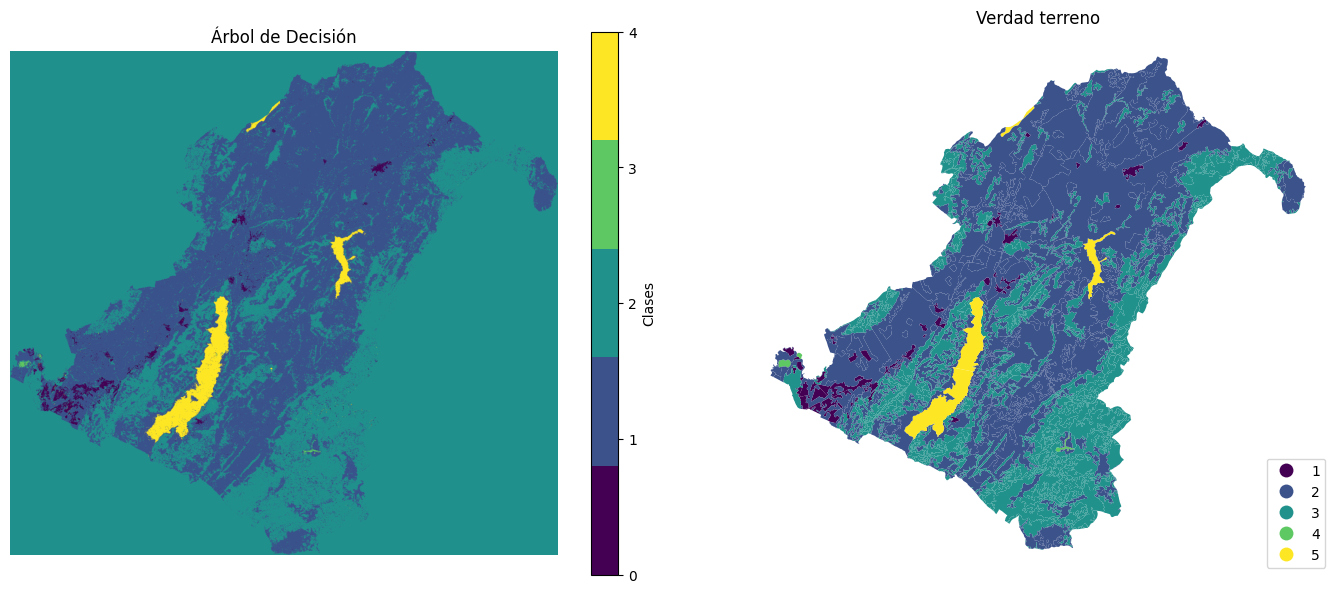

In [67]:
visualizar_prediccion(pred_full_dt, gdf, campo="nivel_1", titulo_pred="Árbol de Decisión")


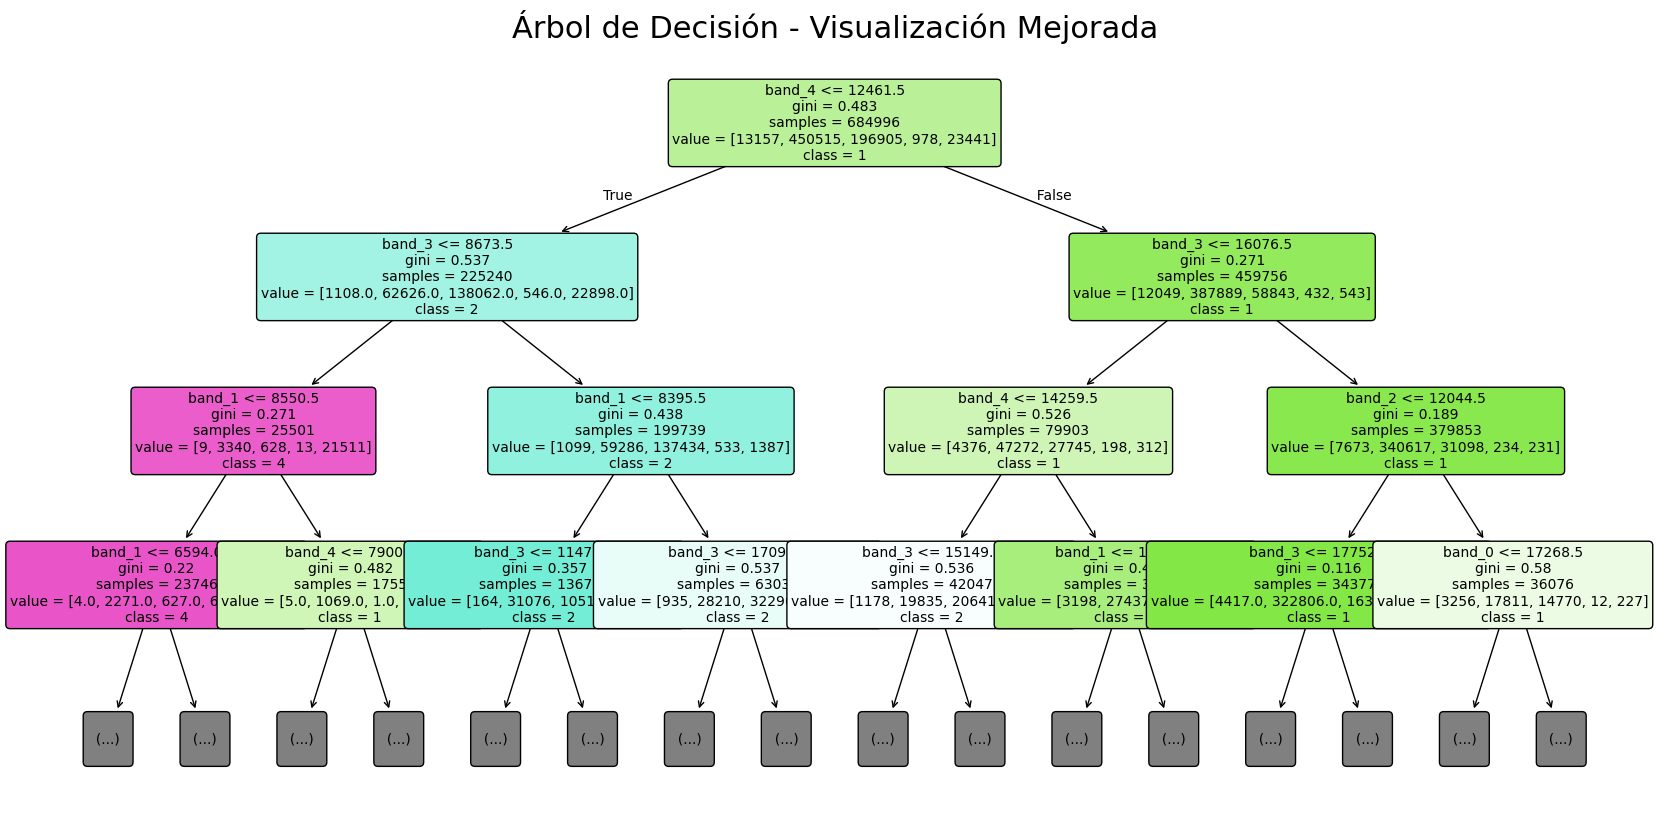

In [69]:

plt.figure(figsize=(20, 10))
tree.plot_tree(
    clf,
    filled=True,
    rounded=True,
    feature_names=[f"band_{i}" for i in range(X_tr.shape[1])],
    class_names=[str(c) for c in np.unique(y_tr)],
    fontsize=10,
    max_depth=3
)
plt.title("Árbol de Decisión - Visualización Mejorada", fontsize=22)
plt.show()

In [ ]:
path_proc = Path("/content/2_procesado")
path_model = Path("/content/3_modelo")
path_pred  = Path("/content/4_prediccion")

### Random Forest

In [73]:
from sklearn.ensemble import RandomForestClassifier



# Modelo Random Forest
rf = RandomForestClassifier(
    n_estimators=25,        # número de árboles en el bosque
    max_depth=20,         # deja que los árboles crezcan
    random_state=42,

)

# Entrenar
rf.fit(X_tr, y_tr)



RandomForestClassifier(max_depth=20, n_estimators=25, random_state=42)

Guardar modelo entrenado

In [74]:

path_model = Path("/content/3_modelo")
path_model.mkdir(parents=True, exist_ok=True)
joblib.dump(rf, path_model/"random_forest.joblib")



['/content/3_modelo/random_forest.joblib']

In [75]:

y_pred = rf.predict(X_te)

print("\nReporte de Clasificación:\n")
print(classification_report(y_te, y_pred, target_names=nombres_clases))

# Matriz de confusión
print("Matriz de Confusión:\n")
print(confusion_matrix(y_te, y_pred))




Reporte de Clasificación:

                               precision    recall  f1-score   support

 Territorios Artificializados       0.74      0.44      0.55      3289
        Territorios Agrícolas       0.92      0.90      0.91    112629
Bosques y Áreas Seminaturales       0.79      0.85      0.82     49226
                Áreas Húmedas       0.70      0.20      0.31       245
          Superficies de Agua       0.93      0.97      0.95      5860

                     accuracy                           0.88    171249
                    macro avg       0.82      0.67      0.71    171249
                 weighted avg       0.88      0.88      0.88    171249

Matriz de Confusión:

[[  1444   1408    400      7     30]
 [   361 101321  10550      5    392]
 [    96   7480  41610      5     35]
 [     0    131     65     49      0]
 [    38    103     46      4   5669]]


In [76]:
pred_full_rf = predecir_y_guardar(
    modelo = rf,
    stack = stack,
    meta = meta,
    ruta_salida = "/content/4_prediccion/pred_random_forest.tif"
)


Prediciendo todos los píxeles…
Predicción guardada en: /content/4_prediccion/pred_random_forest.tif


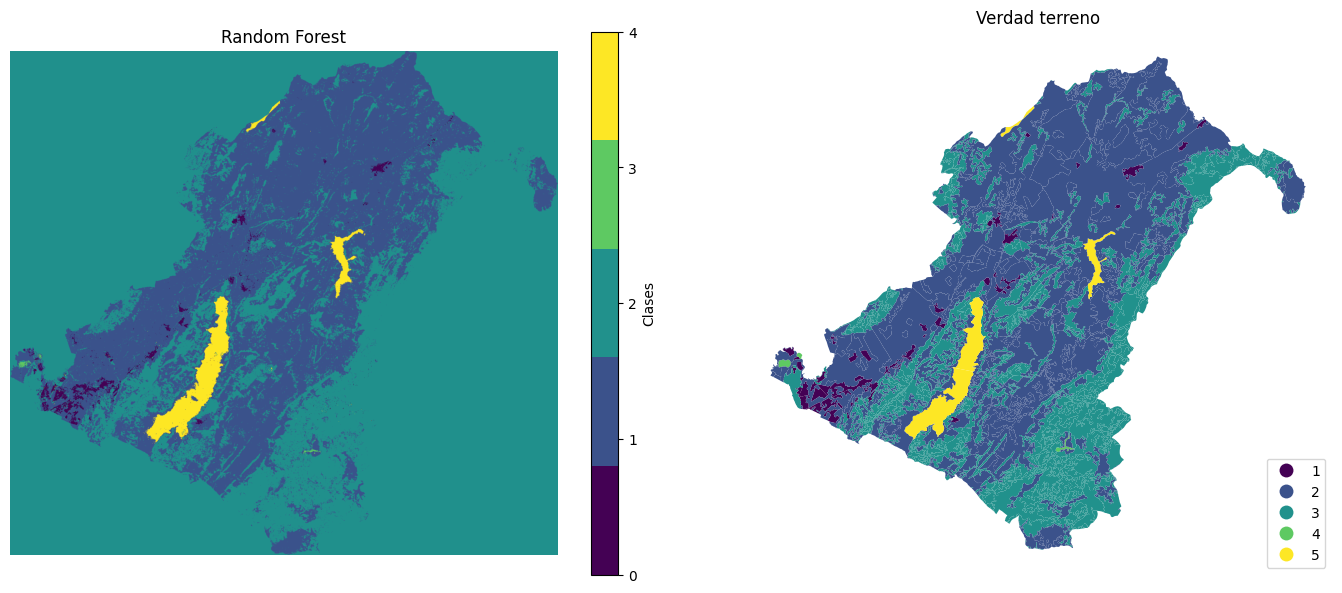

In [77]:
visualizar_prediccion(pred_full_rf, gdf, campo="nivel_1", titulo_pred="Random Forest")


### XGboost

In [79]:
import xgboost as xgb

In [80]:
# Se crea un modelo XGBoost para clasificación multiclase
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y_tr)),  # Se define el número total de clases a predecir
    n_estimators=30,  # Número de árboles en el modelo
    learning_rate=0.1,  # Tamaño de paso del gradiente (controla la velocidad de aprendizaje)
    max_depth=20,  # Profundidad máxima del árbol
    subsample=0.8,  # Usa solo 80% de muestras por árbol para reducir sobreajuste
    random_state=42  # Semilla para resultados reproducibles
)


xgb_model.fit(X_tr, y_tr)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=30,
              n_jobs=None, num_class=5, ...)

In [81]:
y_pred = xgb_model.predict(X_te)

print("\nReporte de Clasificación:\n")
print(classification_report(y_te, y_pred, target_names=nombres_clases))

# Matriz de confusión
print("Matriz de Confusión:\n")
print(confusion_matrix(y_te, y_pred))


Reporte de Clasificación:

                               precision    recall  f1-score   support

 Territorios Artificializados       0.75      0.44      0.55      3289
        Territorios Agrícolas       0.91      0.90      0.91    112629
Bosques y Áreas Seminaturales       0.80      0.83      0.82     49226
                Áreas Húmedas       0.75      0.23      0.36       245
          Superficies de Agua       0.93      0.96      0.95      5860

                     accuracy                           0.88    171249
                    macro avg       0.83      0.67      0.72    171249
                 weighted avg       0.88      0.88      0.88    171249

Matriz de Confusión:

[[  1444   1428    390      3     24]
 [   373 101893   9983      7    373]
 [    91   8005  41090      4     36]
 [     1    129     57     57      1]
 [    27    141     47      5   5640]]


In [82]:
pred_full_xgb =predecir_y_guardar(
    modelo = xgb_model,
    stack = stack,
    meta = meta,
    ruta_salida = "/content/4_prediccion/pred_xgb_model.tif"
)

Prediciendo todos los píxeles…
Predicción guardada en: /content/4_prediccion/pred_xgb_model.tif


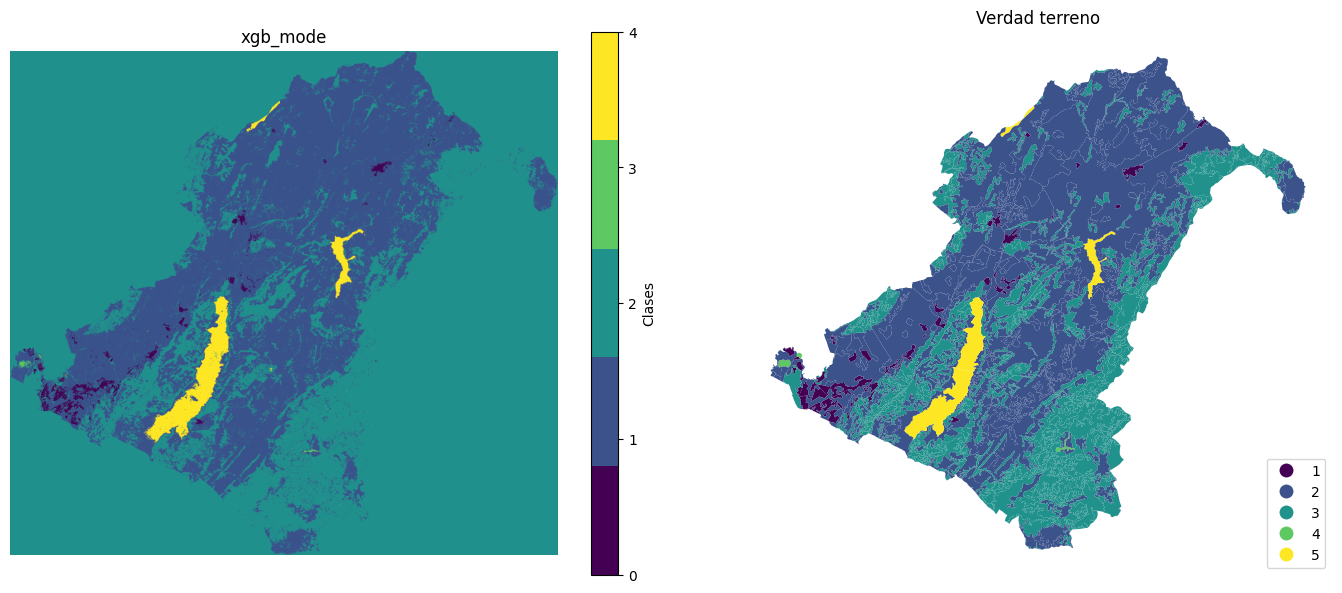

In [83]:
visualizar_prediccion(pred_full_xgb, gdf, campo="nivel_1", titulo_pred="xgb_mode")